# Push SWAG

## Introduction

In this notebook, we run SWAG using PusH. SWAG stands for Stochastic Weight Averaging Gaussian, and it is used to build a distribution of parameters for a pre trained network by averaging parameter values over a set number of swag epochs. We begin by training a standard neural network for some number of epochs, then we start tracking and calculating the first and second moments of our model's parameters. The first moment is a running average of our parameters, updated after each swag epoch. The second moment is simply the first moment squared. After training for swag epochs, we use the first and second moments to sample parameter states.

To get an inference result, we choose to sample say 20 parameter states, and average the predictions from these 20. The first and second moment defines our distribution to sample from, and can be a simple gaussian.

In [1]:
import experiments.nns.simplenet.simplenet
from experiments.nns.simplenet.simplenet import SimpleNet
import torch.optim as optim
import torch.nn as nn


model = SimpleNet(num_classes=10, in_chans= 1, scale=1, network_idx=1, mode=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Dataset

In [2]:
import torch
import os
from torch.utils.data import DataLoader
from torchvision import datasets, transforms



notebook_directory = os.path.dirname(os.path.abspath("deep_ensemble_mnist.ipynb"))
parent_directory = os.path.abspath(os.path.join(notebook_directory, "..","..","..","..","..","..",".."))
mnist_directory = os.path.abspath(os.path.join(parent_directory, "/usr/data1/vision/data/"))
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root=mnist_directory, train=True, download=False, transform=transform)
test_dataset = datasets.MNIST(root=mnist_directory, train=False, download=False, transform=transform)

# Save the subset indices inside mnist_directory
subset_save_path = os.path.join(mnist_directory, "subset_indices.pth")

# Load the subset indices from mnist_directory
loaded_subset_indices = torch.load(subset_save_path)

# Create the subset using the loaded indices
loaded_train_subset = torch.utils.data.Subset(train_dataset, loaded_subset_indices)

In [3]:
# Create data loaders
batch_size = 512
train_loader = DataLoader(loaded_train_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [4]:
import torch
import push.bayes.swag

num_ensembles = 2
swag_epochs = 25
pretrain_epochs = 75
loss_fn = torch.nn.CrossEntropyLoss()

two_particle_mswag = push.bayes.swag.train_mswag(
    train_loader,
    loss_fn,
    pretrain_epochs,
    swag_epochs,
    SimpleNet, 10, 1, 1, 1, 2,
    num_devices=2,
    num_models = 4,
)


100%|██████████| 25/25 [01:01<00:00,  2.47s/it]


In [7]:
two_model_outputs = two_particle_mswag.posterior_pred(test_loader, loss_fn, num_samples=5, mode=["mode","std","mean_prob",], f_reg=False)

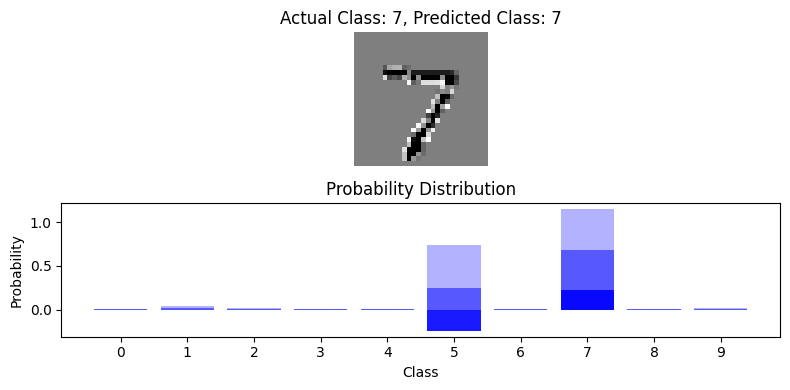

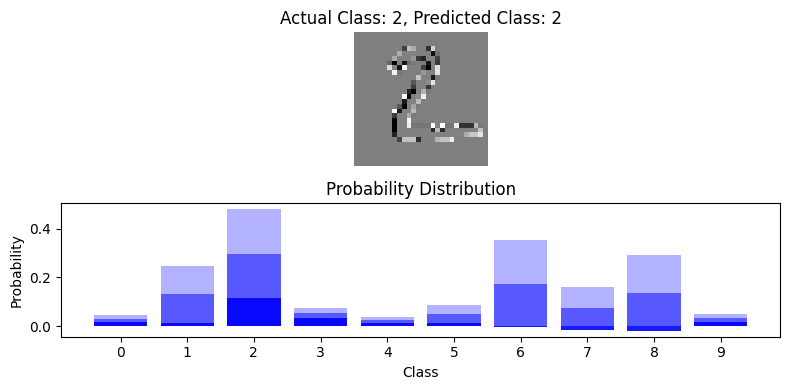

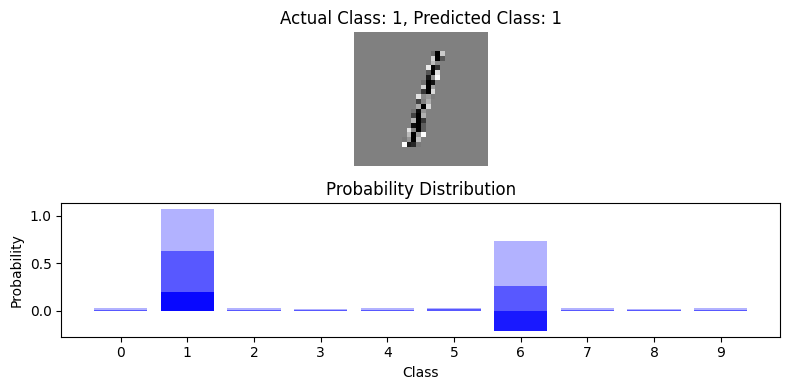

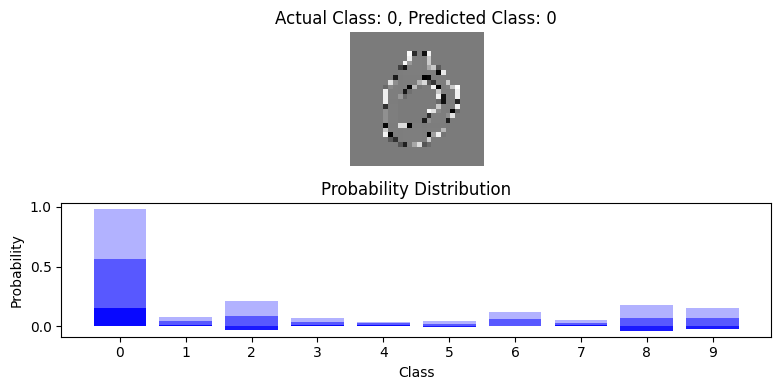

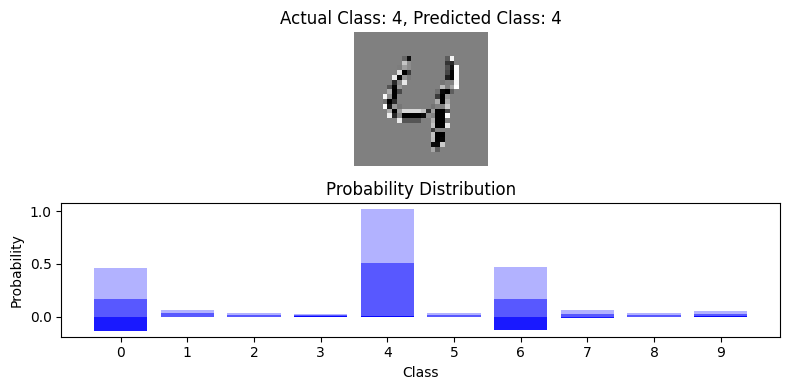

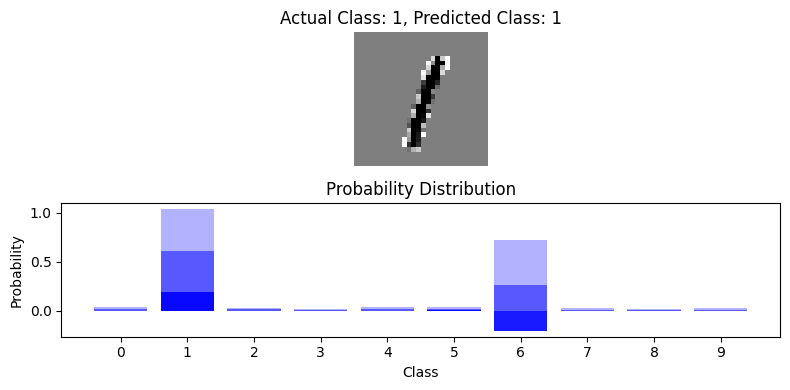

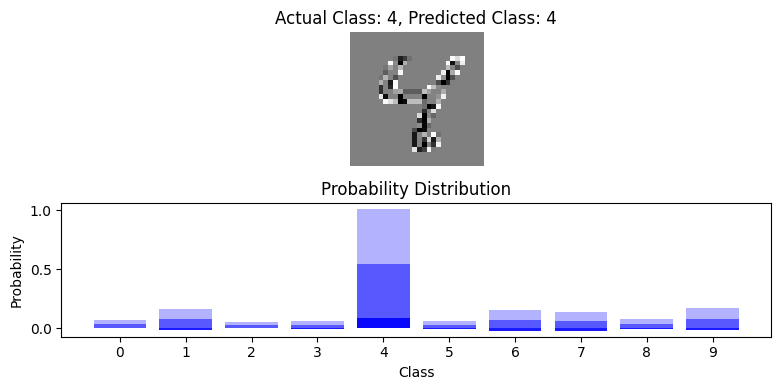

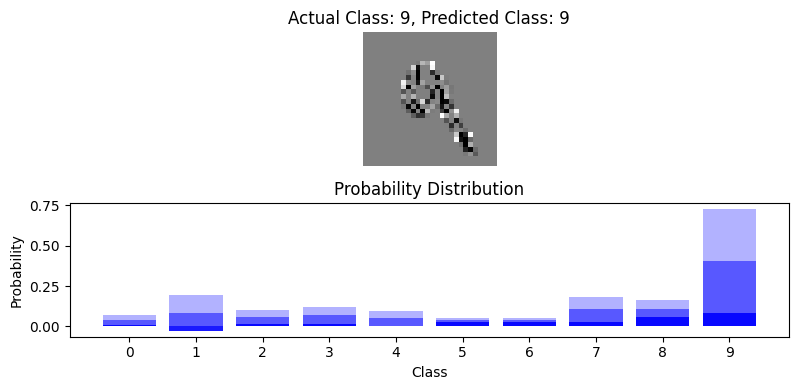

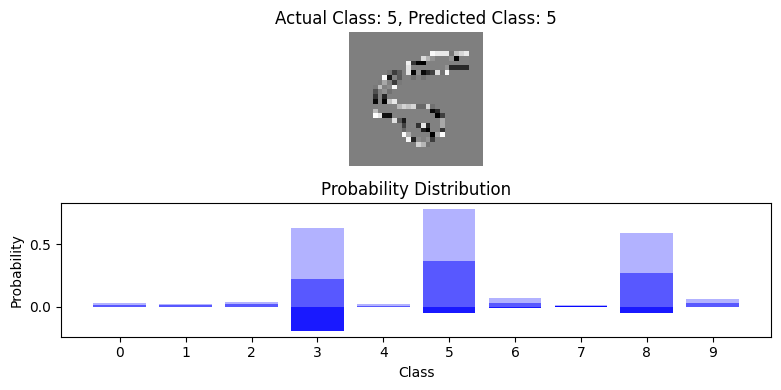

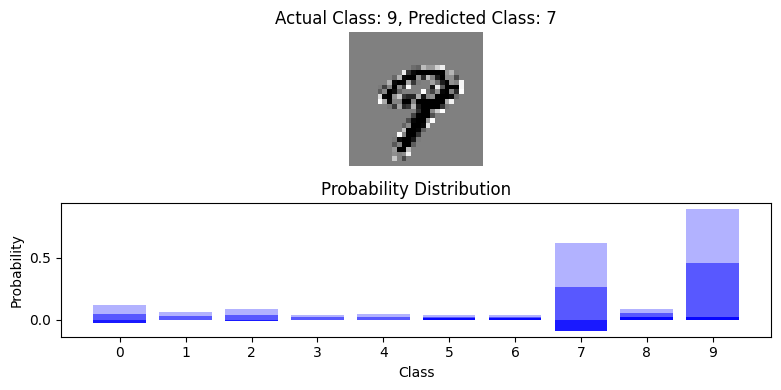

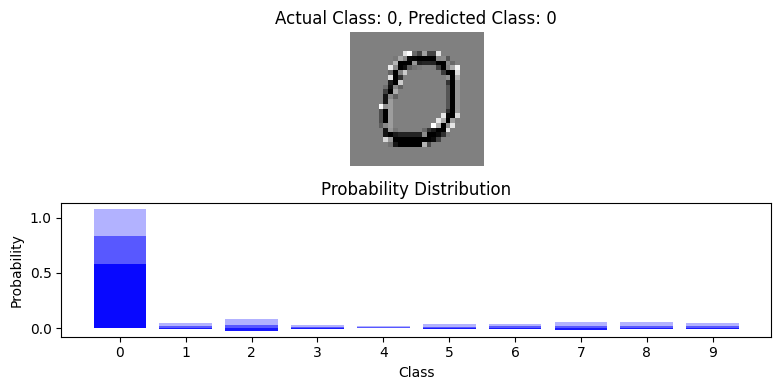

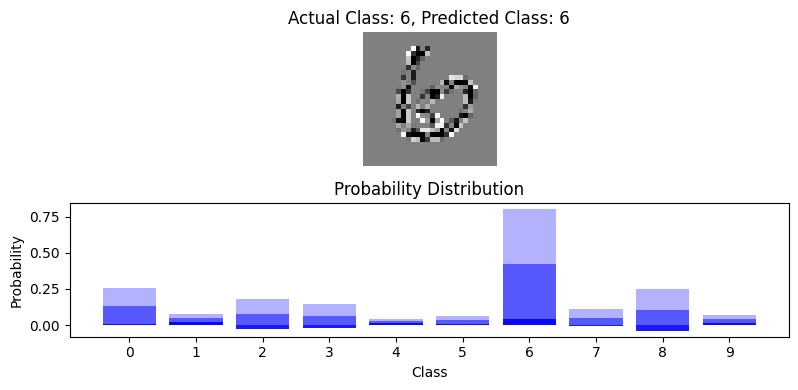

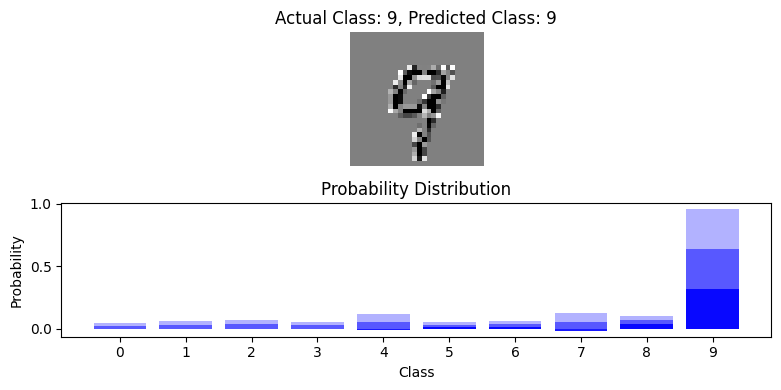

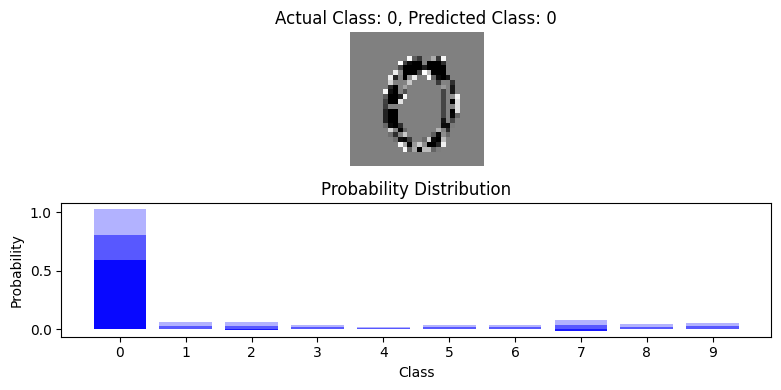

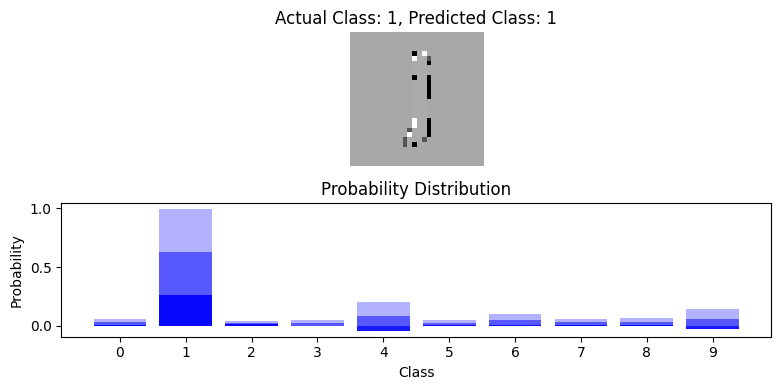

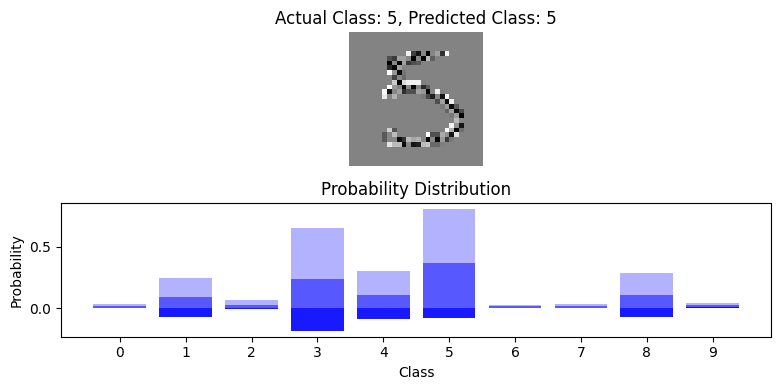

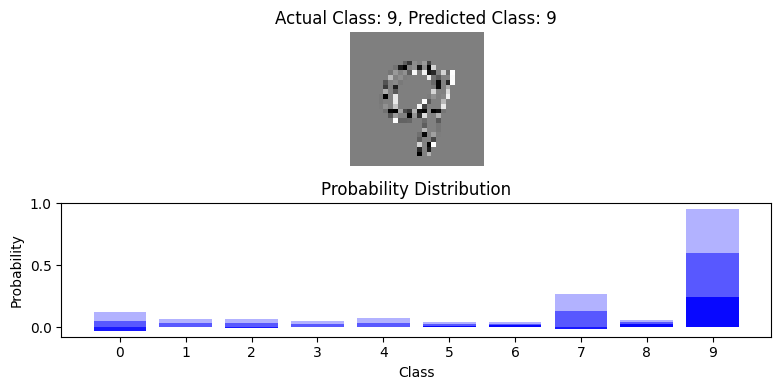

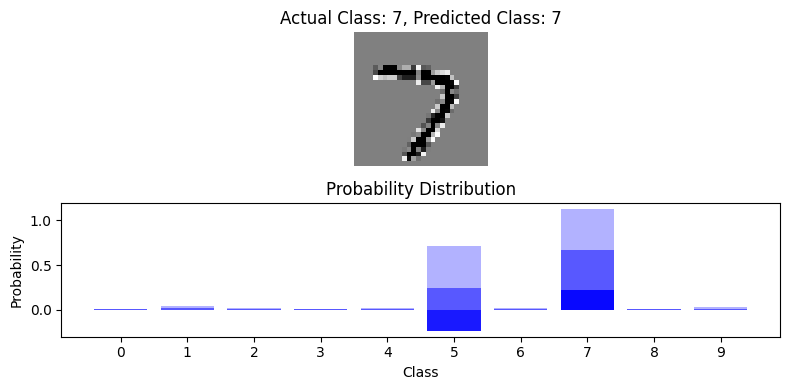

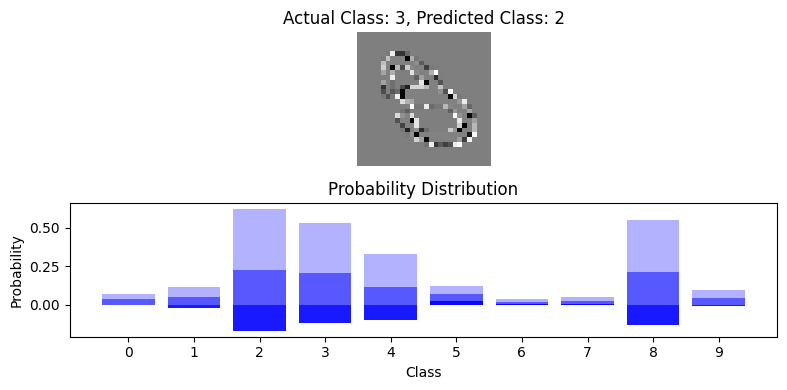

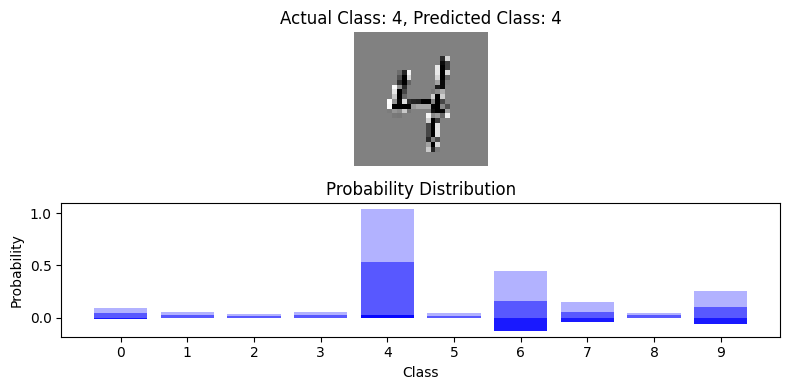

In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms

# Assuming two_model_outputs is your model's output tensor containing predicted classes
# and two_model_probabilities is the tensor containing probabilities
predicted_classes = two_model_outputs["mode"]
probabilities = two_model_outputs["mean_prob"]
std = two_model_outputs["std"]

# Convert input_images to float tensor before normalization
input_images_float = test_dataset.data.float()

# Add an extra channel dimension (assuming grayscale images)
input_images_float = input_images_float.unsqueeze(1)

# Unnormalize and convert input_images to numpy array
unnormalize = transforms.Compose([transforms.Normalize(mean=-0.5/0.5, std=1/0.5),
                                 transforms.ToPILImage()])

input_images_np = np.array([np.array(unnormalize(img)) for img in input_images_float])

# Get actual labels from the dataset
actual_labels = test_dataset.targets

# Display a few images along with their predicted classes and probability distribution
num_images_to_display = 20

for i in range(num_images_to_display):
    plt.figure(figsize=(8, 4))

    # Plot the image
    plt.subplot(2, 1, 1)
    plt.imshow(input_images_np[i], cmap='gray')
    plt.title(f'Actual Class: {actual_labels[i]}, Predicted Class: {predicted_classes[i]}')
    plt.axis('off')

    # Plot the probability distribution with x-axis values going from 0 to 9
    plt.subplot(2, 1, 2)
    plt.bar(np.arange(0, 10), probabilities[i], color='blue', alpha=0.5)
    plt.bar(np.arange(0, 10), probabilities[i]+std[i], color='blue', alpha=0.3)
    plt.bar(np.arange(0, 10), probabilities[i]-std[i], color='blue', alpha=0.9)
    plt.title("Probability Distribution")
    plt.xlabel("Class")
    plt.ylabel("Probability")

    # Set the x-axis ticks explicitly
    plt.xticks(np.arange(0, 10))

    plt.tight_layout()

plt.show()
